In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from src.dataset import ProteinDataset
from src.utils import train_model, test_model
import torch
from src.model import ChemicalShiftsPredictor, ChemicalShiftsPredictorAttention
import numpy as np

/tmp/ipykernel_1511/1992590518.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
all_ucb_predictions = pd.read_csv("all_ucb_predictions.csv")

csv_file = 'data/strict.csv'
chemical_shifts_df = pd.read_csv(csv_file)
joined = pd.merge(chemical_shifts_df, all_ucb_predictions, on=['ID', 'seq_index'], how='inner', suffixes=('', '_ucb'))


In [3]:
# taking our predictions from data/our_predictions.csv
# and joining them with the chemical shifts data
# to get the chemical shifts for our predictions
our_predictions_nn = pd.read_csv("data/our_predictions.csv")
joined = pd.merge(joined, our_predictions_nn, on=['ID', 'seq_index'], how='inner', suffixes=('', '_our_nn'))


In [4]:
our_prediction_cat_n = pd.read_csv("test_n_catboost_prostt5_5000.csv")
joined = pd.merge(joined, our_prediction_cat_n, on=['ID', 'seq_index'], how='inner', suffixes=('', '_our_cat_n'))

In [5]:
our_prediction_can_h = pd.read_csv("test_h_catboost_prostt5.csv")
joined = pd.merge(joined, our_prediction_can_h, on=['ID', 'seq_index'], how='inner', suffixes=('', '_our_cat_h'))

In [6]:
baselines_train = chemical_shifts_df[~chemical_shifts_df['ID'].isin(joined['ID'])]

# mean baseline
mean_baseline = baselines_train['N'].mean()
joined[f'mean_baseline_N'] = mean_baseline

# mean per sequence baseline
baseline2 = baselines_train.groupby('seq')['N'].mean()
joined[f"mean_per_res_baseline_N"] = joined['seq'].map(baseline2)

In [7]:
baselines_train = chemical_shifts_df[~chemical_shifts_df['ID'].isin(joined['ID'])]

# mean baseline
mean_baseline = baselines_train["H"].mean()
joined[f'mean_baseline_H'] = mean_baseline

# mean per sequence baseline
baseline2 = baselines_train.groupby('seq')["H"].mean()
joined[f"mean_per_res_baseline_H"] = joined['seq'].map(baseline2)

In [8]:
n_filtered = joined.dropna(subset=['N', 'N_ucb'], axis=0)

In [9]:
# bootstrap first baseline to estimate 0.95 confidence interval for RMSE
errors = (n_filtered ['N'] - n_filtered [f'mean_baseline_N']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))
    
bootstrap_rmse = np.array(bootstrap_rmse)
mean_baseline_rmse = np.sqrt(errors.mean())
mean_baseline_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - mean_baseline_rmse

# bootstrap second baseline to estimate 0.95 confidence interval for RMSE
errors = (n_filtered ['N'] - n_filtered [f'mean_per_res_baseline_N']) ** 2
bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))

bootstrap_rmse = np.array(bootstrap_rmse)
mean_per_res_baseline_rmse = np.sqrt(errors.mean())
mean_per_res_baseline_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - mean_per_res_baseline_rmse


# bootstrap UCB to estimate 0.95 confidence interval for RMSE
errors = (joined['N'] - joined[f'N_ucb']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))

bootstrap_rmse = np.array(bootstrap_rmse)
ucb_rmse = np.sqrt(errors.mean())
ucb_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - ucb_rmse

# bootstrap our model to estimate 0.95 confidence interval for RMSE
errors = (joined['N'] - joined[f'N_our']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))
    
bootstrap_rmse = np.array(bootstrap_rmse)
our_nn_rmse = np.sqrt(errors.mean())
our_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - our_nn_rmse


# bootstrap our cat n to estimate 0.95 confidence interval for RMSE
errors = (joined['N'] - joined[f'N_cat']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))

bootstrap_rmse = np.array(bootstrap_rmse)
our_cat_n_rmse = np.sqrt(errors.mean())
our_cat_n_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - our_cat_n_rmse

In [10]:
our_cat_n_rmse

3.1080577660792037

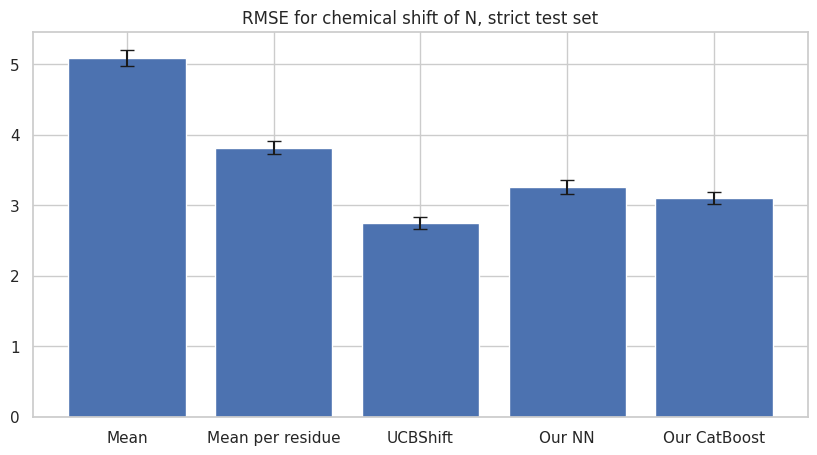

In [12]:
# make bar plot showing RMSE and 95% CI for each method
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))
y_errors = np.abs(np.stack([mean_baseline_rmse_ci, mean_per_res_baseline_rmse_ci, ucb_rmse_ci, our_rmse_ci, our_cat_n_rmse_ci], axis=0).T)
# make ax wider
ax.bar(x=['Mean', 'Mean per residue', 'UCBShift', "Our NN", "Our CatBoost"], height=[mean_baseline_rmse, mean_per_res_baseline_rmse, ucb_rmse, our_nn_rmse, our_cat_n_rmse], yerr=y_errors, capsize=5)
ax.set_title("RMSE for chemical shift of N, strict test set");

In [13]:
h_filtered = joined.dropna(subset=['H', 'H_ucb'], axis=0)

# bootstrap first baseline to estimate 0.95 confidence interval for RMSE
errors = (h_filtered ['H'] - h_filtered [f'mean_baseline_H']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))
    
bootstrap_rmse = np.array(bootstrap_rmse)
mean_baseline_rmse = np.sqrt(errors.mean())
mean_baseline_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - mean_baseline_rmse

# bootstrap second baseline to estimate 0.95 confidence interval for RMSE
errors = (h_filtered ['H'] - h_filtered [f'mean_per_res_baseline_H']) ** 2
bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))

bootstrap_rmse = np.array(bootstrap_rmse)
mean_per_res_baseline_rmse = np.sqrt(errors.mean())
mean_per_res_baseline_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - mean_per_res_baseline_rmse


# bootstrap UCB to estimate 0.95 confidence interval for RMSE
errors = (h_filtered['H'] - h_filtered[f'H_ucb']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))

bootstrap_rmse = np.array(bootstrap_rmse)
ucb_rmse = np.sqrt(errors.mean())
ucb_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - ucb_rmse

# bootstrap our model to estimate 0.95 confidence interval for RMSE
errors = (h_filtered['H'] - h_filtered[f'H_our']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))
    
bootstrap_rmse = np.array(bootstrap_rmse)
our_nn_rmse = np.sqrt(errors.mean())
our_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - our_nn_rmse


# bootstrap our cat h to estimate 0.95 confidence interval for RMSE
errors = (h_filtered['H'] - h_filtered[f'H_cat']) ** 2

bootstrap_rmse = []
for i in range(1000):
    sample = errors.sample(frac=0.5, replace=True)
    bootstrap_rmse.append(np.sqrt(sample.mean()))
    
bootstrap_rmse = np.array(bootstrap_rmse)
our_cat_h_rmse = np.sqrt(errors.mean())
our_cat_h_rmse_ci = np.quantile(bootstrap_rmse, [0.025, 0.975]) - our_cat_h_rmse

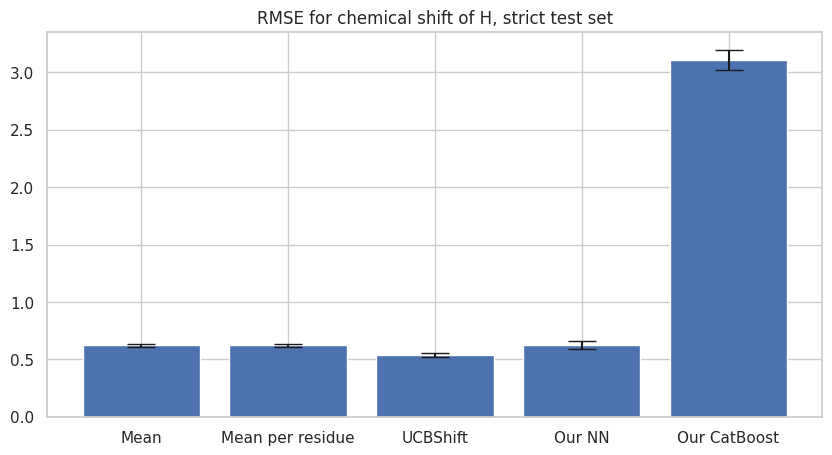

In [14]:
# make bar plot showing RMSE and 95% CI for each method
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))
y_errors = np.abs(np.stack([mean_baseline_rmse_ci, mean_per_res_baseline_rmse_ci, ucb_rmse_ci, our_rmse_ci, our_cat_n_rmse_ci], axis=0).T)
ax.bar(x=['Mean', 'Mean per residue', 'UCBShift', "Our NN", "Our CatBoost"], height=[mean_baseline_rmse, mean_per_res_baseline_rmse, ucb_rmse, mean_baseline_rmse, our_cat_n_rmse], yerr=y_errors, capsize=10)
ax.set_title("RMSE for chemical shift of H, strict test set");